In [1]:
import os, sys
from os.path import dirname
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from unittest.mock import MagicMock, patch
from performance_data.data_table import PhaseData, DataTable
from performance_data.data_model import PhaseGenerator, TierModel, DataModel, load_and_predict
from performance_data.data_model import DeepNNModel
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from functools import partial
import loguru
loguru.logger.remove()
loguru.logger.add(sys.stderr, level="INFO")

1

In [2]:
def plot_fit(model):
    """
    Plots the fit of the model on the training data.
    """
    # Make predictions on the training data
    y_test_pred = model.predict(model.X_test)

    # Plot the fit of the model on the training data
    plt.scatter(model.y_test, y_test_pred, color='blue')
    plt.ylabel("Predictions")
    plt.xlabel("True Values")
    plt.title("Fit of the Model on the Training Data")
    plt.show()

2023-03-20 09:13:28.914 | INFO     | performance_data.data_model:load_data:289 - Ingesting input data in dataframe of size (500, 9)
2023-03-20 09:13:28.915 | INFO     | performance_data.data_model:load_data:290 - Target tiers: ['lfs_bw', 'fs1_bw']
2023-03-20 09:13:28.916 | INFO     | performance_data.data_model:_prepare_data:389 - Preparing data...
2023-03-20 09:13:28.926 | INFO     | performance_data.data_model:_prepare_input_data:307 - Preparing input data with columns: ['nodes', 'read_volume', 'write_volume', 'read_io_pattern', 'write_io_pattern', 'read_io_size', 'write_io_size', 'lfs_bw', 'fs1_bw']
2023-03-20 09:13:28.943 | INFO     | performance_data.data_model:__init__:251 - Initializing DataModel.
/home_nfs/mimounis/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home_nfs/mimounis/anaconda3/env

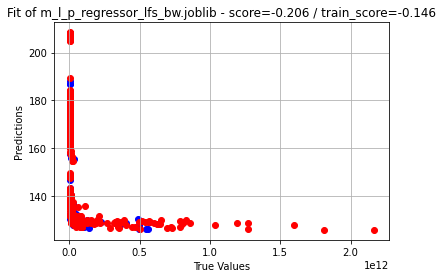

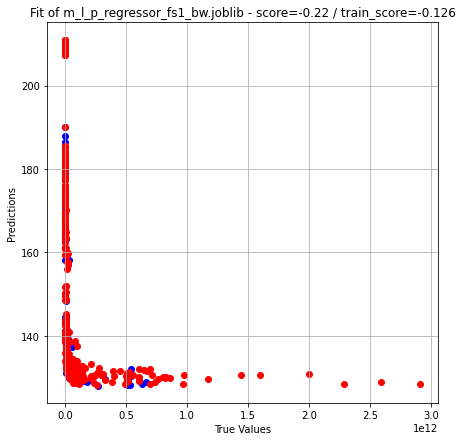

2023-03-20 09:13:33.025 | INFO     | performance_data.data_model:load_data:289 - Ingesting input data in dataframe of size (500, 9)
2023-03-20 09:13:33.025 | INFO     | performance_data.data_model:load_data:290 - Target tiers: ['lfs_bw', 'fs1_bw']
2023-03-20 09:13:33.026 | INFO     | performance_data.data_model:_prepare_data:389 - Preparing data...
2023-03-20 09:13:33.036 | INFO     | performance_data.data_model:_prepare_input_data:307 - Preparing input data with columns: ['nodes', 'read_volume', 'write_volume', 'read_io_pattern', 'write_io_pattern', 'read_io_size', 'write_io_size', 'lfs_bw', 'fs1_bw']
2023-03-20 09:13:33.054 | INFO     | performance_data.data_model:__init__:251 - Initializing DataModel.
2023-03-20 09:13:33.124 | INFO     | performance_data.data_model:train_model:447 - Model LinearRegression() for Tier: lfs_bw trained with score:0.0601
2023-03-20 09:13:33.155 | INFO     | performance_data.data_model:train_model:447 - Model LinearRegression() for Tier: fs1_bw trained wi

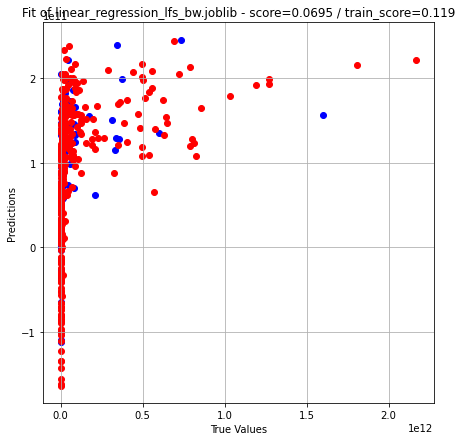

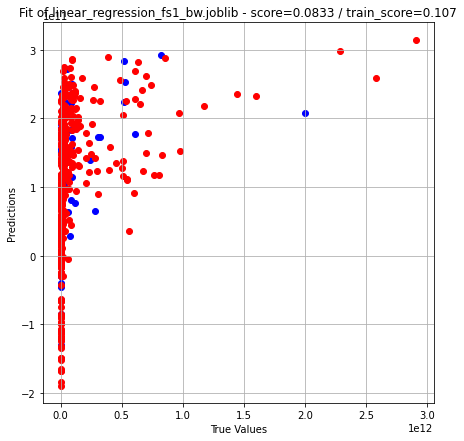

2023-03-20 09:13:33.795 | INFO     | performance_data.data_model:load_data:289 - Ingesting input data in dataframe of size (500, 9)
2023-03-20 09:13:33.796 | INFO     | performance_data.data_model:load_data:290 - Target tiers: ['lfs_bw', 'fs1_bw']
2023-03-20 09:13:33.797 | INFO     | performance_data.data_model:_prepare_data:389 - Preparing data...
2023-03-20 09:13:33.805 | INFO     | performance_data.data_model:_prepare_input_data:307 - Preparing input data with columns: ['nodes', 'read_volume', 'write_volume', 'read_io_pattern', 'write_io_pattern', 'read_io_size', 'write_io_size', 'lfs_bw', 'fs1_bw']
2023-03-20 09:13:33.822 | INFO     | performance_data.data_model:__init__:251 - Initializing DataModel.
2023-03-20 09:13:33.850 | INFO     | performance_data.data_model:train_model:447 - Model Ridge() for Tier: lfs_bw trained with score:0.0474
2023-03-20 09:13:33.877 | INFO     | performance_data.data_model:train_model:447 - Model Ridge() for Tier: fs1_bw trained with score:0.0812


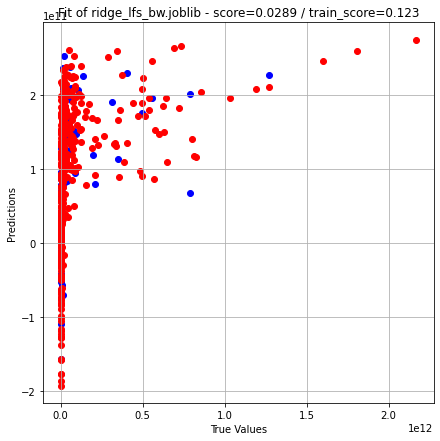

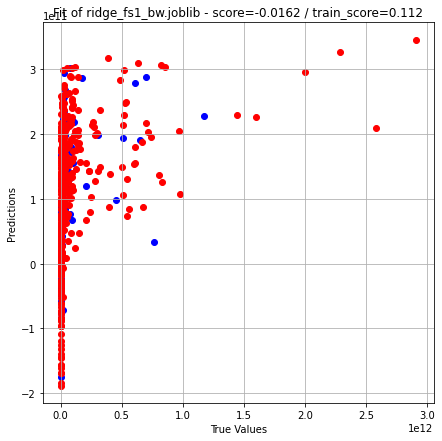

2023-03-20 09:13:34.363 | INFO     | performance_data.data_model:load_data:289 - Ingesting input data in dataframe of size (500, 9)
2023-03-20 09:13:34.364 | INFO     | performance_data.data_model:load_data:290 - Target tiers: ['lfs_bw', 'fs1_bw']
2023-03-20 09:13:34.365 | INFO     | performance_data.data_model:_prepare_data:389 - Preparing data...
2023-03-20 09:13:34.374 | INFO     | performance_data.data_model:_prepare_input_data:307 - Preparing input data with columns: ['nodes', 'read_volume', 'write_volume', 'read_io_pattern', 'write_io_pattern', 'read_io_size', 'write_io_size', 'lfs_bw', 'fs1_bw']
2023-03-20 09:13:34.390 | INFO     | performance_data.data_model:__init__:251 - Initializing DataModel.
/home_nfs/mimounis/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. 

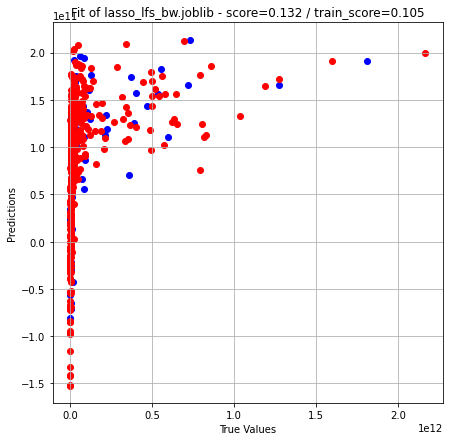

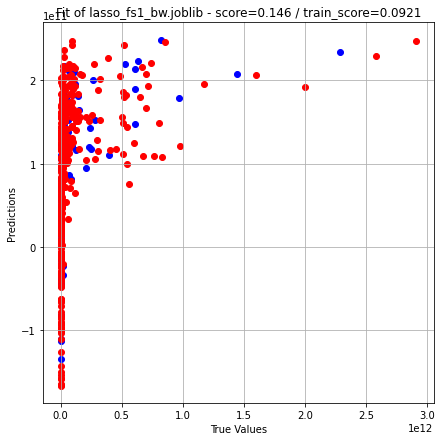

2023-03-20 09:13:34.997 | INFO     | performance_data.data_model:load_data:289 - Ingesting input data in dataframe of size (500, 9)
2023-03-20 09:13:34.998 | INFO     | performance_data.data_model:load_data:290 - Target tiers: ['lfs_bw', 'fs1_bw']
2023-03-20 09:13:34.999 | INFO     | performance_data.data_model:_prepare_data:389 - Preparing data...
2023-03-20 09:13:35.008 | INFO     | performance_data.data_model:_prepare_input_data:307 - Preparing input data with columns: ['nodes', 'read_volume', 'write_volume', 'read_io_pattern', 'write_io_pattern', 'read_io_size', 'write_io_size', 'lfs_bw', 'fs1_bw']
2023-03-20 09:13:35.024 | INFO     | performance_data.data_model:__init__:251 - Initializing DataModel.
2023-03-20 09:13:35.052 | INFO     | performance_data.data_model:train_model:447 - Model ElasticNet() for Tier: lfs_bw trained with score:0.0471
2023-03-20 09:13:35.078 | INFO     | performance_data.data_model:train_model:447 - Model ElasticNet() for Tier: fs1_bw trained with score:0.0

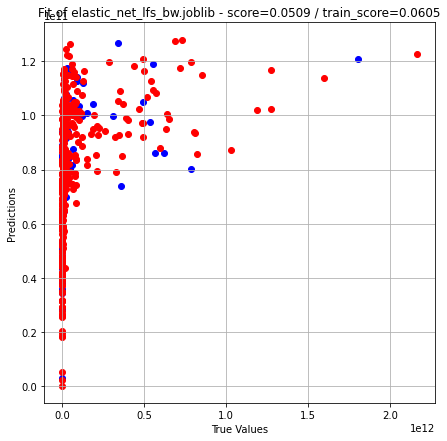

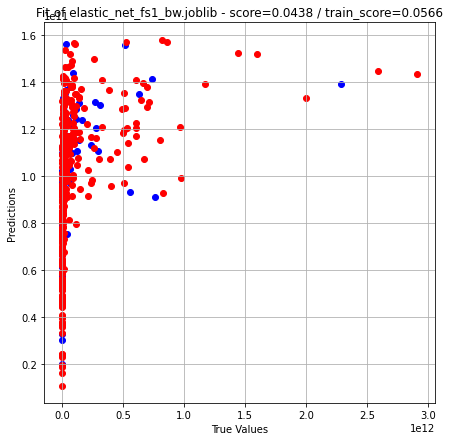

2023-03-20 09:13:35.603 | INFO     | performance_data.data_model:load_data:289 - Ingesting input data in dataframe of size (500, 9)
2023-03-20 09:13:35.604 | INFO     | performance_data.data_model:load_data:290 - Target tiers: ['lfs_bw', 'fs1_bw']
2023-03-20 09:13:35.605 | INFO     | performance_data.data_model:_prepare_data:389 - Preparing data...
2023-03-20 09:13:35.613 | INFO     | performance_data.data_model:_prepare_input_data:307 - Preparing input data with columns: ['nodes', 'read_volume', 'write_volume', 'read_io_pattern', 'write_io_pattern', 'read_io_size', 'write_io_size', 'lfs_bw', 'fs1_bw']
2023-03-20 09:13:35.630 | INFO     | performance_data.data_model:__init__:251 - Initializing DataModel.
2023-03-20 09:13:35.664 | INFO     | performance_data.data_model:train_model:447 - Model DecisionTreeRegressor() for Tier: lfs_bw trained with score:0.64
2023-03-20 09:13:35.697 | INFO     | performance_data.data_model:train_model:447 - Model DecisionTreeRegressor() for Tier: fs1_bw tr

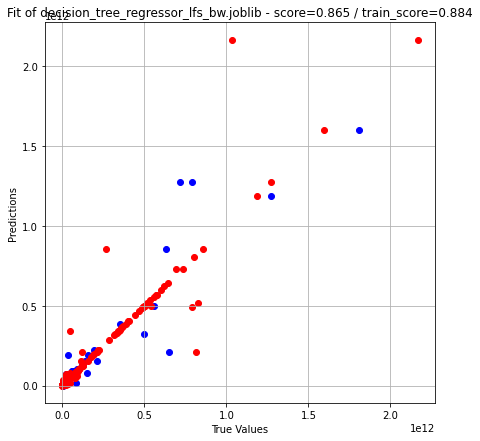

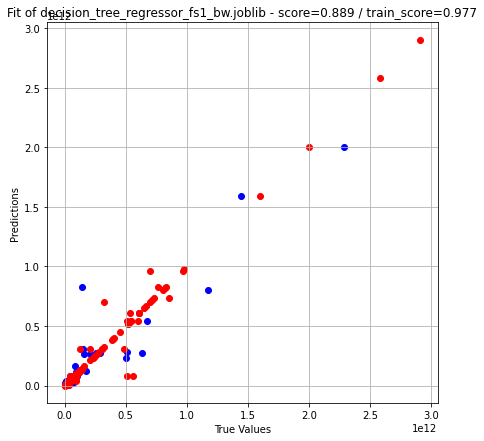

2023-03-20 09:13:36.214 | INFO     | performance_data.data_model:load_data:289 - Ingesting input data in dataframe of size (500, 9)
2023-03-20 09:13:36.215 | INFO     | performance_data.data_model:load_data:290 - Target tiers: ['lfs_bw', 'fs1_bw']
2023-03-20 09:13:36.215 | INFO     | performance_data.data_model:_prepare_data:389 - Preparing data...
2023-03-20 09:13:36.224 | INFO     | performance_data.data_model:_prepare_input_data:307 - Preparing input data with columns: ['nodes', 'read_volume', 'write_volume', 'read_io_pattern', 'write_io_pattern', 'read_io_size', 'write_io_size', 'lfs_bw', 'fs1_bw']
2023-03-20 09:13:36.241 | INFO     | performance_data.data_model:__init__:251 - Initializing DataModel.
2023-03-20 09:13:37.654 | INFO     | performance_data.data_model:train_model:447 - Model RandomForestRegressor() for Tier: lfs_bw trained with score:0.871
2023-03-20 09:13:37.730 | INFO     | performance_data.data_model:save_model:475 - Model random_forest_regressor_lfs_bw.joblib for '

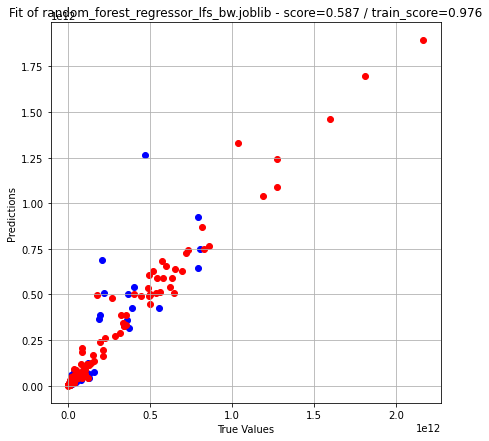

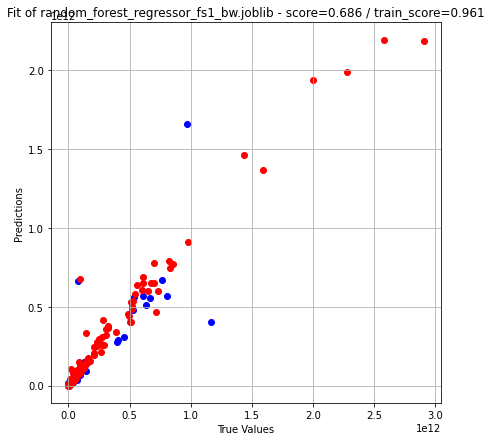

2023-03-20 09:13:39.871 | INFO     | performance_data.data_model:load_data:289 - Ingesting input data in dataframe of size (500, 9)
2023-03-20 09:13:39.872 | INFO     | performance_data.data_model:load_data:290 - Target tiers: ['lfs_bw', 'fs1_bw']
2023-03-20 09:13:39.873 | INFO     | performance_data.data_model:_prepare_data:389 - Preparing data...
2023-03-20 09:13:39.883 | INFO     | performance_data.data_model:_prepare_input_data:307 - Preparing input data with columns: ['nodes', 'read_volume', 'write_volume', 'read_io_pattern', 'write_io_pattern', 'read_io_size', 'write_io_size', 'lfs_bw', 'fs1_bw']
2023-03-20 09:13:39.901 | INFO     | performance_data.data_model:__init__:251 - Initializing DataModel.
2023-03-20 09:13:40.295 | INFO     | performance_data.data_model:train_model:447 - Model GradientBoostingRegressor() for Tier: lfs_bw trained with score:0.83
2023-03-20 09:13:40.311 | INFO     | performance_data.data_model:save_model:475 - Model gradient_boosting_regressor_lfs_bw.jobli

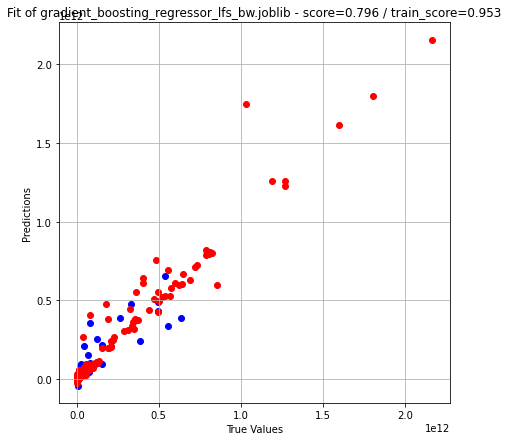

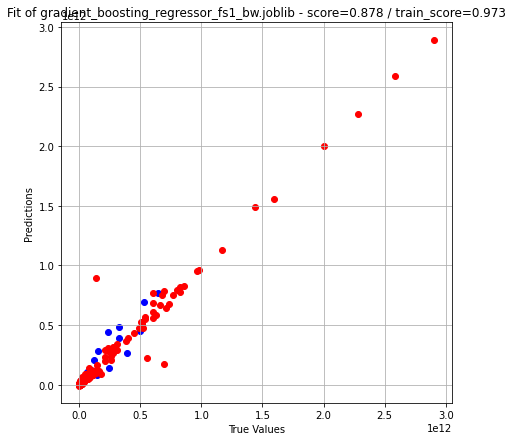

2023-03-20 09:13:41.237 | INFO     | performance_data.data_model:load_data:289 - Ingesting input data in dataframe of size (500, 9)
2023-03-20 09:13:41.238 | INFO     | performance_data.data_model:load_data:290 - Target tiers: ['lfs_bw', 'fs1_bw']
2023-03-20 09:13:41.239 | INFO     | performance_data.data_model:_prepare_data:389 - Preparing data...
2023-03-20 09:13:41.248 | INFO     | performance_data.data_model:_prepare_input_data:307 - Preparing input data with columns: ['nodes', 'read_volume', 'write_volume', 'read_io_pattern', 'write_io_pattern', 'read_io_size', 'write_io_size', 'lfs_bw', 'fs1_bw']
2023-03-20 09:13:41.264 | INFO     | performance_data.data_model:__init__:251 - Initializing DataModel.
2023-03-20 09:13:41.351 | INFO     | performance_data.data_model:train_model:447 - Model SVR() for Tier: lfs_bw trained with score:-0.117
2023-03-20 09:13:41.436 | INFO     | performance_data.data_model:train_model:447 - Model SVR() for Tier: fs1_bw trained with score:-0.12


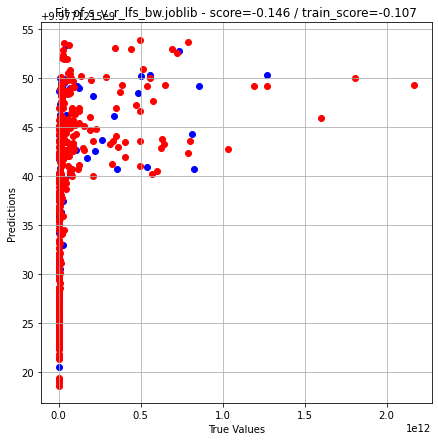

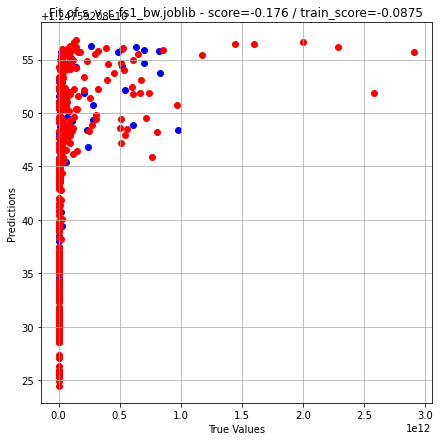

In [3]:
save_dir = "/home_nfs/mimounis/iosea-wp3-recommandation-system/performance_data/performance_data/notebooks"

for model in [MLPRegressor, LinearRegression, Ridge, Lasso, ElasticNet, 
              DecisionTreeRegressor, RandomForestRegressor, GradientBoostingRegressor, SVR]:


#dmodel = DeepNNModel#(depth=3, width=32, input_dim=14)
#dmodel = partial(DeepNNModel, depth=15, width=32)

  
    model_1 = TierModel(regressor=model())
    model_2 = TierModel(regressor=model())
    models_list = [model_1, model_2]
    data_model = DataModel(models=models_list)
    trained_models = data_model.train_model(save_dir=save_dir)
    for col in data_model.y.columns:
        X_test = data_model.X_test
        y_test = data_model.y_test[col]
        y_test_pred = data_model.models[col].predict(data_model.X_test)
        y_train_pred = data_model.models[col].predict(data_model.X_train)
        train_score = data_model.models[col].score(data_model.X_train, data_model.y_train[col])
        score = data_model.models[col].score(X_test, y_test)
        
        plt.scatter(y_test, y_test_pred, color='blue')
        plt.scatter(data_model.y_train[col], y_train_pred, color='red')
        plt.ylabel("Predictions")
        plt.xlabel("True Values")
        plt.title(f"Fit of {data_model.model_name(col)} - score={score:.3} / train_score={train_score:.3}")
        plt.rcParams["figure.figsize"] = (7,7)
        plt.grid()
        plt.show()

In [13]:
model_path = "/home_nfs/mimounis/iosea-wp3-recommandation-system/performance_data/performance_data/notebooks/decision_tree_regressor_lfs_bw.joblib"

new_data = pd.DataFrame({
            'nodes': [1, 1],
            'read_io_size': [8e6, 4e3],
            'write_io_size': [8e6, 2e6],
            'read_volume': [169e6, 7.6e6],
            'write_volume': [330e6, 492e6],
            'read_io_pattern': ['stride', 'rand'],
            'write_io_pattern': ['stride', 'uncl'],
        })

predictions = load_and_predict(model_path, new_data, iops=True)
print(predictions.values.flatten())


[[1.        ]
 [0.24620456]]
[5.03018109e+08 9.61155285e+08]


#### Imports for cluster_simulator and app_decomposer

In [5]:
import os
import unittest
import requests
import urllib3
from app_decomposer.utils_demo import *
from loguru import logger
from unittest.mock import patch
from pprint import pprint
from os.path import dirname, abspath
import warnings
warnings.filterwarnings('ignore')
from performance_data.data_table import PhaseData, DataTable
from performance_data import DATASET_FILE
from app_decomposer import DEFAULT_CONFIGURATION, KIWI_CONFIG, CURRENT_DIR, API_DICT_TS, IOI_SAMPLING_PERIOD, DATASET_SOURCE
from app_decomposer.api_connector import request_delegator
from app_decomposer.config_parser import Configuration
from app_decomposer.api_connector import TimeSeries
from cluster_simulator.analytics import *
from loguru import logger
import simpy
from loguru import logger
import time
import numpy as np
import pandas as pd
from cluster_simulator.utils import convex_hull
from cluster_simulator.cluster import Cluster, Tier, EphemeralTier, bandwidth_share_model, compute_share_model, get_tier, convert_size
from cluster_simulator.phase import DelayPhase, ComputePhase, IOPhase
from cluster_simulator.application import Application
from cluster_simulator.analytics import display_run
from cluster_simulator.ephemeral_placement import ClusterBlackBox

#### Old fashion simulation

application duration = 222.5


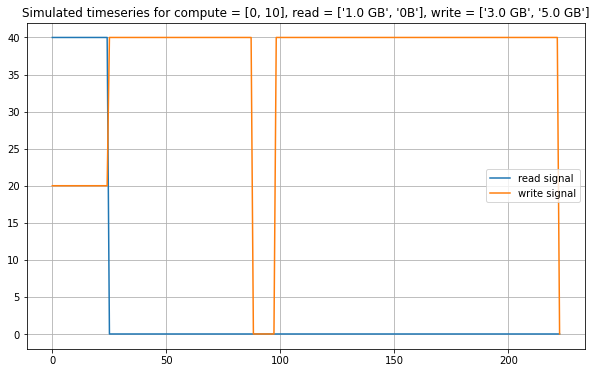

In [6]:
# sim env an data
env = simpy.Environment()
data = simpy.Store(env)
# tier perfs
nvram_bandwidth = {'read':  {'seq': 800, 'rand': 600},
                        'write': {'seq': 400, 'rand': 400}}
ssd_bandwidth = {'read':  {'seq': 240, 'rand': 180},
                    'write': {'seq': 100, 'rand': 100}}
hdd_bandwidth = {'read':  {'seq': 80, 'rand': 80},
                    'write': {'seq': 40, 'rand': 40}}

# registering Tiers
hdd_tier = Tier(env, 'HDD', max_bandwidth=hdd_bandwidth, capacity=1e12)
ssd_tier = Tier(env, 'SSD', max_bandwidth=ssd_bandwidth, capacity=200e9)
nvram_tier = Tier(env, 'NVRAM', max_bandwidth=nvram_bandwidth,
                        capacity=10e9)
# registering Ephemeral Tier
bb = EphemeralTier(env, name="BB", persistent_tier=hdd_tier,
                        max_bandwidth=nvram_bandwidth, capacity=10e9)

# Define the cluster with 1 persistent and 1 ephemeral
cluster = Cluster(env, tiers=[hdd_tier], ephemeral_tier=bb)
jobid=0
# logger
#env = simpy.Environment()
logger.remove()
# Simple app: read 1GB -> compute 10s -> write 5GB
# placement
placement = [0, 0]
use_bb = [False, False]
compute=[0, 10]
read=[1e9, 0]
write=[3e9, 5e9]
# simulate the app execution
app1 = Application(env, compute=compute, read=read, write=write, data=data)
#app2 = Application(env, compute=[0, 5],  read=[2e9, 0], write=[7e9, 0], data=data)
env.process(app1.run(cluster, placement=placement, use_bb=use_bb))
#env.process(app2.run(cluster, placement=placement, use_bb=use_bb))
env.run()
print(f"application duration = {app1.get_fitness()}")

output = get_execution_signal_3(data)

sim_time = np.array(output[app1.name]["time"])
sim_read_bw = np.array(output[app1.name]["read_bw"])
sim_write_bw = np.array(output[app1.name]["write_bw"])

fig = plt.figure(figsize=(10, 6))
plt.plot(sim_time, sim_read_bw, label="read signal")
plt.plot(sim_time, sim_write_bw, label="write signal")
plt.grid(True)
plt.legend()
plt.title(f"Simulated timeseries for compute = {compute}, read = {list(map(convert_size, read))}, write = {list(map(convert_size, write))}")
plt.show()

#### New way to simulate

In [7]:
import yaml, simpy
# sim env an data
env = simpy.Environment()
data = simpy.Store(env)
# tier perfs
cluster_config = """
defaults:
  compute_nodes: 1
  cores_per_node: 2

tiers:
  - name: tier1
    capacity: 100.e+9
    max_bandwidth:
      read:
        seq: 200
        rand: 100
      write:
        seq: 100
        rand: 50

  - name: tier2
    capacity: 500.e+9
    max_bandwidth:
      read:
        seq: 500
        rand: 300
      write:
        seq: 200
        rand: 150

  - name: lfs
    capacity: 500.e+9
    bandwidth_model_path: gradient_boosting_regressor_lfs_bw.joblib

ephemeral_tier:
  name: ephemeral
  persistent_tier: tier1
  capacity: 1.e+9
  max_bandwidth:
    read:
      seq: 500
      rand: 300
    write:
      seq: 200
      rand: 150
"""
# nvram_bandwidth = {'read':  {'seq': 800, 'rand': 600},
#                         'write': {'seq': 400, 'rand': 400}}
# ssd_bandwidth = {'read':  {'seq': 240, 'rand': 180},
#                     'write': {'seq': 100, 'rand': 100}}
# hdd_bandwidth = {'read':  {'seq': 80, 'rand': 80},
#                     'write': {'seq': 40, 'rand': 40}}

# # registering Tiers
# hdd_tier = Tier(env, 'HDD', max_bandwidth=hdd_bandwidth, capacity=1e12)
# ssd_tier = Tier(env, 'SSD', max_bandwidth=ssd_bandwidth, capacity=200e9)
# nvram_tier = Tier(env, 'NVRAM', max_bandwidth=nvram_bandwidth,
#                         capacity=10e9)
# # registering Ephemeral Tier
# bb = EphemeralTier(env, name="BB", persistent_tier=hdd_tier,
#                         max_bandwidth=nvram_bandwidth, capacity=10e9)

# Define the cluster with 1 persistent and 1 ephemeral
cluster = Cluster(env, config_path=cluster_config)
#print(cluster)
print(cluster.tiers[2].bandwidth_model_path)
print(cluster)

gradient_boosting_regressor_lfs_bw.joblib
Cluster with 1 compute nodes 
Each having 2 cores in total 

-------------------
Tier:(Tier) tier1 with capacity = 100.0 GB
Operation    Pattern      Bandwidth MB/s
read         seq          200         
read         rand         100         
write        seq          100         
write        rand         50          

-------------------
Tier:(Tier) tier2 with capacity = 500.0 GB
Operation    Pattern      Bandwidth MB/s
read         seq          500         
read         rand         300         
write        seq          200         
write        rand         150         

-------------------
Tier:(Tier) lfs with capacity = 500.0 GB
Operation    Pattern      Bandwidth MB/s
Bandwidth model path: gradient_boosting_regressor_lfs_bw.joblib

-------------------
Tier:(EphemeralTier) ephemeral with capacity = 1.0 GB
Operation    Pattern      Bandwidth MB/s
read         seq          500         
read         rand         300         
write        se

In [8]:
new_data = pd.DataFrame({
            'nodes': [1, 1],
            'read_io_size': [8e6, 6e6],
            'write_io_size': [8e6, 6e6],
            'read_volume': [169e6, 200e6],
            'write_volume': [330e6, 200e6],
            'read_io_pattern': ['stride', 'seq'],
            'write_io_pattern': ['stride', 'seq'],
        })
bw = cluster.tiers[2].get_max_bandwidth(new_data=new_data)
# expects 503 MB/s (lfs) and 1GB/s (fs1)
print(bw)

[[1.  ]
 [0.75]]
[1.89010188e+09 2.30046966e+09]


#### Real IOI Job

In [9]:
jobid=3918
dataset_path = os.path.join(dirname(dirname(os.getcwd())), "performance_data", "performance_data", "dataset")
#%%capture
logger.remove()
def decompose_ioi_job(jobid):
    with patch.object(ComplexDecomposer, 'get_job_timeseries') as mock_get_timeseries:
        with patch.object(Configuration, 'get_kc_token') as mock_get_kc_token:
            with patch.object(ComplexDecomposer, 'get_job_node_count') as mock_get_node_count:
                mock_get_timeseries.return_value = get_job_timeseries_from_file(job_id=jobid)
                mock_get_kc_token.return_value = 'token'
                mock_get_node_count.return_value = 1
                # init the job decomposer
                #cd = ComplexDecomposer(v0_threshold=0.02)
                cd = ComplexDecomposer(v0_threshold=0.01)
                return cd
# Launch decomposition on the signal
cd = decompose_ioi_job(jobid=jobid)
# Showing representation
representation = cd.get_job_representation(merge_clusters=True)
phases_features = pd.DataFrame(cd.get_phases_features(representation))
print(phases_features)
bw = cluster.tiers[2].get_max_bandwidth(new_data=pd.DataFrame(phases_features))
print(bw)

    job_id  nodes  read_volume  write_volume read_io_pattern write_io_pattern  \
0  unknown      1            0             0            uncl             uncl   
1  unknown      1   1730808132             0             seq             uncl   
2  unknown      1   1588775126    2038785597             seq              seq   
3  unknown      1   3168984277    4139017218             seq              seq   
4  unknown      1      3023280    5334798849             seq              seq   
5  unknown      1      7054320    5305154361             seq              seq   
6  unknown      1      2519400    5334798849             seq              seq   
7  unknown      1            0             0            uncl             uncl   

   read_io_size  write_io_size        ioi_bw  
0  0.000000e+00   0.000000e+00  0.000000e+00  
1  2.131537e+06   0.000000e+00  3.461616e+08  
2  1.217452e+06   2.067734e+06  3.627561e+08  
3  3.486231e+06   2.069509e+06  5.928329e+08  
4  5.030416e+03   5.334799e+06  2.6